In [71]:
import json
from datasets import load_dataset
import plotly.express as px
#visualize
import matplotlib.pyplot as plt
import os
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import pandas as pd

%matplotlib inline

os.chdir('/Users/jon/Documents/DSDM/term_2/adv_meth_nlp/nlp-final/')

# Data exploration

First load the dataset.

In [27]:
import json
from datasets import load_dataset

# Load the English part of the dataset
train_dataset = load_dataset('nlpaueb/multi_eurlex', 'en', split='train')
test_dataset = load_dataset('nlpaueb/multi_eurlex', 'en', split='test')
val_dataset = load_dataset('nlpaueb/multi_eurlex', 'en', split='validation')

Found cached dataset multi_eurlex (/Users/jon/.cache/huggingface/datasets/nlpaueb___multi_eurlex/en/1.0.0/1addee7110a20c2b01cc3de89456786482e4eea1d2ead0bea3d5383b16cc9fce)
Found cached dataset multi_eurlex (/Users/jon/.cache/huggingface/datasets/nlpaueb___multi_eurlex/en/1.0.0/1addee7110a20c2b01cc3de89456786482e4eea1d2ead0bea3d5383b16cc9fce)
Found cached dataset multi_eurlex (/Users/jon/.cache/huggingface/datasets/nlpaueb___multi_eurlex/en/1.0.0/1addee7110a20c2b01cc3de89456786482e4eea1d2ead0bea3d5383b16cc9fce)


`eurovoc_id` is the ID of a certain area of government activity.

`level` refers to the specificity of a certain topic. For example, european parliament is level 0, quantum computing is level 7.

In [30]:
# Load (label_id, descriptor) mapping 
with open('./data/eurovoc_descriptors.json') as jsonl_file:
    eurovoc_descriptors =  json.load(jsonl_file)

# Get feature map info
train_classlabel = train_dataset.features["labels"].feature
test_classlabel = test_dataset.features["labels"].feature
val_classlabel = val_dataset.features["labels"].feature

# Load (label_id, descriptor) mapping 
with open('./data/eurovoc_concepts.json') as jsonl_file:
    eurovoc_concepts =  json.load(jsonl_file)


Let's take a look at the distribution of labels. 

In [64]:
def get_agg_df(dataset, classlabel):
    df_agg = []
    for i, sample in enumerate(dataset):    
        for label_id in sample['labels']:
            result = {}
            result['celex_id'] = sample['celex_id']
            result['label_id'] = label_id
            result['eurovoc_id'] = classlabel.int2str(label_id)
            result['eurovoc_desc'] = eurovoc_descriptors[classlabel.int2str(label_id)]['en']
            df_agg.append(result)
            # Get the EuroVoc level for the current label ID
            for level, ids in eurovoc_concepts.items():
                if classlabel.int2str(label_id) in ids:
                    result['eurovoc_level'] = level
                    break
    df_agg = pd.DataFrame(df_agg)
    return(df_agg)

train_agg_df = get_agg_df(train_dataset, train_classlabel)
test_agg_df = get_agg_df(test_dataset, test_classlabel)
val_agg_df = get_agg_df(val_dataset, val_classlabel)
df = pd.concat([train_agg_df, test_agg_df, val_agg_df], ignore_index=True)
df['source'] = pd.Series(['train'] * len(train_agg_df) + ['test'] * len(test_agg_df) + ['val'] * len(val_agg_df), dtype='string')

In [70]:
df.head()

,celex_id,label_id,eurovoc_id,eurovoc_desc,eurovoc_level,source
0,32003R1012,2,100148,finance,level_1,train
1,32003R1012,5,100143,international relations,level_1,train
2,32003R1012,10,100142,politics,level_1,train
3,32003R1012,8,100154,transport,level_1,train
4,32003R1012,3,100147,trade,level_1,train


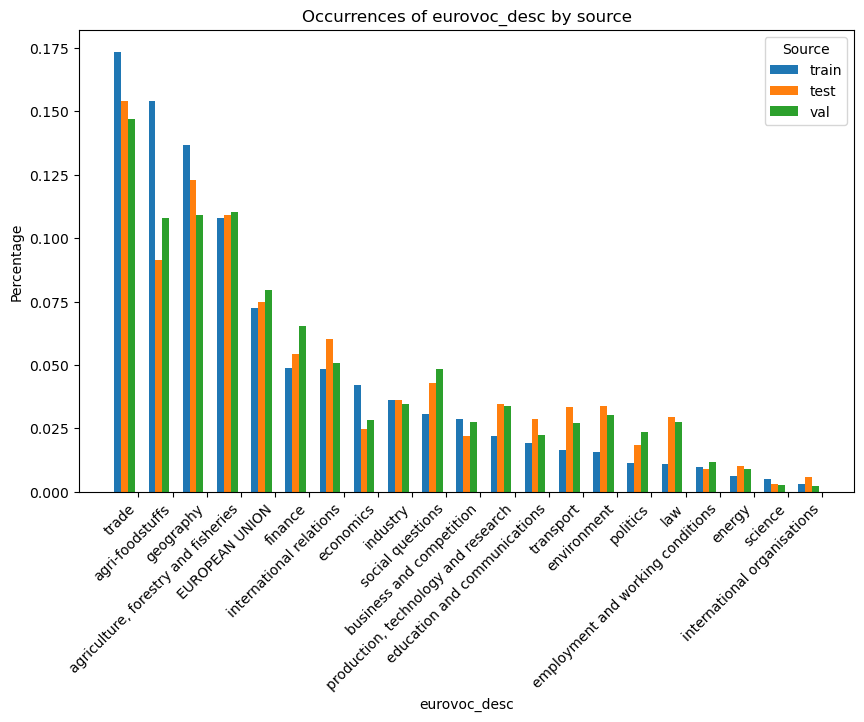

In [65]:

# Group by eurovoc_desc and source, and count occurrences
df_grouped = df.groupby(['eurovoc_desc', 'source']).size().reset_index(name='count')

# Pivot the table to have source as columns and eurovoc_desc as index
df_pivot = df_grouped.pivot_table(index='eurovoc_desc', columns='source', values='count')

# Divide each column by the total count for that source
df_pivot = df_pivot.divide(df_pivot.sum(axis=0), axis=1)

# Sort the pivot table by the train column in descending order
df_pivot = df_pivot.sort_values(by='train', ascending=False)

# Plot a grouped bar chart
fig, ax = plt.subplots(figsize=(10,6))

x = np.arange(len(df_pivot))
width = 0.2

ax.bar(x - width, df_pivot['train'], width, label='train')
ax.bar(x, df_pivot['test'], width, label='test')
ax.bar(x + width, df_pivot['val'], width, label='val')

# Set the plot title and axes labels
ax.set_title('Occurrences of eurovoc_desc by source')
ax.set_xlabel('eurovoc_desc')
ax.set_ylabel('Percentage')

# Add a legend to the plot
ax.legend(title='Source', loc='upper right')

# Set the x-axis tick positions and labels
xticks = x - width / 2 + 0.5
ax.set_xticks(xticks)
ax.set_xticklabels(df_pivot.index, rotation=45, ha='right')

# Show the plot
plt.show()


## Preprocessing

In [69]:
df_train = train_dataset.to_pandas()
df_train.head()

,celex_id,text,labels
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,"[2, 5, 10, 8, 3, 18, 15]"
1,32008R0284,COMMISSION REGULATION (EC) No 284/2008\nof 27 ...,"[3, 18, 17, 6]"
2,32004D0761,COMMISSION DECISION\nof 26 October 2004\nlayin...,"[17, 19, 10, 6, 15]"
3,31992R2310,COMMISSION REGULATION (EEC) No 2310/92 of 31 J...,"[7, 3, 17, 6]"
4,31995R0423,COUNCIL REGULATION (EC) No 423/95 of 20 Februa...,"[17, 19, 6]"


In [85]:
import nltk
import string
import re
import pandas as pd

# Download the necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define a function to preprocess a single document
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove numbers and punctuation using regex
    text = re.sub(r'[^\w\s]', '', re.sub(r'\d+', '', text))

    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Remove stop words
    stopwords = nltk.corpus.stopwords.words('english')
    filtered_words = [word for word in words if word not in stopwords]

    # Stem the remaining words using Porter Stemmer
    stemmer = nltk.PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in filtered_words]

    # Lemmatize the remaining words using WordNetLemmatizer
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]

    # Join the preprocessed words into a single string
    preprocessed_text = " ".join(lemmatized_words)

    return preprocessed_text

# Preprocess the text in the 'text' column of the DataFrame
df_train['pp_text'] = df_train['text'].apply(preprocess_text)

# Print the preprocessed DataFrame
print(df_train.head())


[nltk_data] Downloading package punkt to /Users/jon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     celex_id                                               text  \
0  32003R1012  commission regulation ec june amending th time...   
1  32008R0284  commission regulation ec march registering cer...   
2  32004D0761  commission decision october laying detailed ru...   
3  31992R2310  commission regulation eec july amending regula...   
4  31995R0423  council regulation ec february amending regula...   

                     labels                                            pp_text  
0  [2, 5, 10, 8, 3, 18, 15]  commiss regul ec june amend th time council re...  
1            [3, 18, 17, 6]  commiss regul ec march regist certain name reg...  
2       [17, 19, 10, 6, 15]  commiss decis octob lay detail rule applic cou...  
3             [7, 3, 17, 6]  commiss regul eec juli amend regul eec buyingi...  
4               [17, 19, 6]  council regul ec februari amend regul eec lay ...  


In [86]:
for i in df_train['pp_text'][:5]:
    print(i)

commiss regul ec june amend th time council regul ec impos certain specif restrict measur direct certain person entiti associ usama bin laden alqaida network taliban repeal council regul ec commiss european commun regard treati establish european commun regard council regul ec may impos certain specif restrict measur direct certain person entiti associ usama bin laden alqaida network taliban repeal council regul ec prohibit export certain good servic afghanistan strengthen flight ban extend freez fund financi resourc respect taliban afghanistan last amend commiss regul ec particular articl first indent thereof wherea annex regul ec list person group entiti cover freez fund econom resourc regul june sanction committe decid amend list person group entiti freez fund econom resourc appli therefor annex amend accordingli adopt regul articl annex regul ec herebi amend accord annex regul articl regul shall enter forc day follow public offici journal european union regul shall bind entireti di

## Baseline (ie non ML solution) + metrics on test set


As baseline we can take each sentence and get most common words used in the text and predict based on that.

In [10]:
text_only = train_exp.groupby('labels', group_keys=False)['text'].apply(lambda x: x.str.split())

In [11]:
train_exp.head()

,celex_id,text,labels
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,2
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,5
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,10
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,8
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,3


In [17]:
concepts_df = []
for i, v in eurovoc_concepts.items():
    result = {'concept_id': i, 'label': v['en']}
    concepts_df.append(result)
concepts_df = pd.DataFrame(concepts_df)
concepts_df.head()

,concept_id,label
0,100149,social questions
1,100160,industry
2,100148,finance
3,100147,trade
4,100152,business and competition


In [18]:
concepts_df['label']

NameError: name 'concepts_df' is not defined

In [17]:
from datasets import load_dataset
dataset = load_dataset('nlpaueb/multi_eurlex', 'all_languages')


AttributeError: 'MultiEURLEX' object has no attribute 'languages'

## RNN solution + metrics on test set


## BERT model + metrics on test set

In [ ]:
..